In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import utils
import datasets_local
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score

In [10]:
SOURCE_LANGS = ['eng', 'deu', 'esp', 'deu-esp', 'deu-esp-eng']
TARGET_LANGS = ['eng', 'deu', 'esp', 'ron']

In [18]:
N_LAYERS = {
    'lealla-large': 24,
}
EMB_DIM = {
    'lealla-large': 256,
}
model_name = "setu4993/LEALLA-large"
model_path_name = model_name.lower().split('/')[-1]
device = torch.device('cuda')


all_layer_ids = list(range(1,N_LAYERS[model_path_name]+1)) + [None]
lns = list(range(1,N_LAYERS[model_path_name]+1)) + ['emb']
layer_ln = '22'
layer_ln = 'emb'

# load val_ds for each lang
val_datasets = {
    lang: None for lang in TARGET_LANGS
}
lang_targets = {
    lang: None for lang in TARGET_LANGS
}

for lang in SOURCE_LANGS:
    mtd = pd.read_csv(f'./data/track_a/train/{lang}.csv')
    targets = [c for c in mtd.columns if c not in ['id', 'text']]
    target_labels = {
        c: mtd[c].to_numpy() for c in targets
    }
    # embeddings = np.load(f'./embeddings/{model_path_name}/{lang}/train_{layer_ln}.npy')
    embeddings = np.load(f'./embeddings/{model_path_name}/{lang}/train.npy')
    _, val_indices = utils.load_split_indices(model_name, lang)
    val_embeddings = embeddings[val_indices]
    val_embeddings = torch.tensor(val_embeddings).to(device)

    val_labels = {
        c: target_labels[c][val_indices] for c in targets
    }
    val_datasets_lang = {
        c: datasets_local.EmbeddingsDataset(val_embeddings, val_labels[c]) for c in targets
    }
    val_datasets[lang] = val_datasets_lang
    lang_targets[lang] = targets

## Romanian is only for testing
lang = 'ron'
mtd = pd.read_csv(f'./data/track_a/train/{lang}.csv')
targets = [c for c in mtd.columns if c not in ['id', 'text']]
target_labels = {
    c: mtd[c].to_numpy() for c in targets
}
val_embeddings = np.load(f'./embeddings/{model_path_name}/{lang}/train.npy')
val_embeddings = torch.tensor(val_embeddings).to(device)

val_labels = {
    c: target_labels[c] for c in targets
}
val_datasets_lang = {
    c: datasets_local.EmbeddingsDataset(val_embeddings, val_labels[c]) for c in targets
}
val_datasets[lang] = val_datasets_lang
lang_targets[lang] = targets


# results[src][tgt][c]
results = {
    lang: {
        lang2: {} for lang2 in TARGET_LANGS
    } for lang in SOURCE_LANGS
}
layer = nn.Linear(EMB_DIM[model_path_name], 1, bias=True)
layer.requires_grad_(False)
layer.eval()
keys = [k for k in layer.state_dict().keys()]

for lang in tqdm(SOURCE_LANGS):
    path = f'./classifiers/{lang}/'
    path_layer = path + f'{layer_ln}/'

    for c in lang_targets[lang]:
        # load weights for lang & target emotion
        st_path = path_layer + f'model_{c}.pt'
        st = torch.load(st_path)
        st = {key: st[key] for key in keys}
        layer.load_state_dict(st)
        layer.to(device)
        for lang2 in TARGET_LANGS:
            if c in val_datasets[lang2].keys(): # target language has emotion c among its tasks
                val_dl = DataLoader(val_datasets[lang2][c], batch_size=512, shuffle=False, num_workers=0)
                _, (val_labels_, val_preds_) = utils.validate(layer, device, val_dl, lambda x, y: torch.ones(1), pred_func=utils.get_predictions_bce)
                f1 = f1_score(val_labels_, val_preds_)
                if lang2 == 'ron':
                    print(sum(val_preds_))
                results[lang][lang2][c] = f1

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_1912/257524347.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st = torch.load(st_path)
/tmp/ipykernel_1912/25752434

210.0
405.0
462.0
379.0
457.0
210.0
297.0


/tmp/ipykernel_1912/257524347.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st = torch.load(st_path)
/tmp/ipykernel_1912/257524347.py:84: FutureWarning: You are using

405.0
462.0
379.0
457.0
210.0
297.0
405.0
462.0


/tmp/ipykernel_1912/257524347.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st = torch.load(st_path)
/tmp/ipykernel_1912/257524347.py:84: FutureWarning: You are using

379.0
457.0
210.0
297.0
405.0
462.0
379.0
457.0


/tmp/ipykernel_1912/257524347.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st = torch.load(st_path)
/tmp/ipykernel_1912/257524347.py:84: FutureWarning: You are using

210.0
297.0
405.0
462.0
379.0
457.0


In [19]:
results

{'eng': {'eng': {'anger': 0.300578034682081,
   'fear': 0.702803738317757,
   'joy': 0.5019011406844107,
   'sadness': 0.549520766773163,
   'surprise': 0.6194690265486726},
  'deu': {'anger': 0.5280898876404494,
   'fear': 0.1722846441947566,
   'joy': 0.3898305084745763,
   'sadness': 0.375,
   'surprise': 0.1285140562248996},
  'esp': {'anger': 0.42,
   'fear': 0.3274336283185841,
   'joy': 0.5482866043613707,
   'sadness': 0.31506849315068497,
   'surprise': 0.36236933797909404},
  'ron': {'anger': 0.30247479376718606,
   'fear': 0.5294117647058822,
   'joy': 0.6289752650176678,
   'sadness': 0.5625,
   'surprise': 0.5086531226486081}},
 'deu': {'eng': {'anger': 0.27906976744186046,
   'fear': 0.36809815950920244,
   'joy': 0.424390243902439,
   'sadness': 0.331877729257642,
   'surprise': 0.5449999999999999},
  'deu': {'anger': 0.7092198581560284,
   'disgust': 0.631578947368421,
   'fear': 0.27272727272727276,
   'joy': 0.5108225108225107,
   'sadness': 0.43404255319148943,
   's

In [14]:
results

{'eng': {'eng': {'anger': 0.31351351351351353,
   'fear': 0.7257731958762885,
   'joy': 0.6135458167330677,
   'sadness': 0.5953177257525084,
   'surprise': 0.5949367088607594},
  'deu': {'anger': 0.5234567901234568,
   'fear': 0.14507772020725387,
   'joy': 0.4320987654320988,
   'sadness': 0.39024390243902435,
   'surprise': 0.1371841155234657},
  'esp': {'anger': 0.4818481848184819,
   'fear': 0.4550898203592815,
   'joy': 0.5705128205128205,
   'sadness': 0.3502824858757062,
   'surprise': 0.39057239057239057},
  'ron': {'anger': 0.0,
   'fear': 0.0,
   'joy': 0.542571931884909,
   'sadness': 0.0,
   'surprise': 0.426078971533517}},
 'deu': {'eng': {'anger': 0.34285714285714286,
   'fear': 0.563855421686747,
   'joy': 0.47150259067357514,
   'sadness': 0.4702194357366771,
   'surprise': 0.5012531328320802},
  'deu': {'anger': 0.7220216606498194,
   'disgust': 0.6433566433566433,
   'fear': 0.2948717948717949,
   'joy': 0.568527918781726,
   'sadness': 0.4573991031390134,
   'surpri

In [20]:
tab = np.zeros((len(SOURCE_LANGS), len(TARGET_LANGS)), dtype=np.float32)

In [21]:
for i, lang in enumerate(SOURCE_LANGS):
    for j, lang2 in enumerate(TARGET_LANGS):
        mf1 = np.mean([results[lang][lang2][c] for c in results[lang][lang2].keys()])
        tab[i][j] = mf1

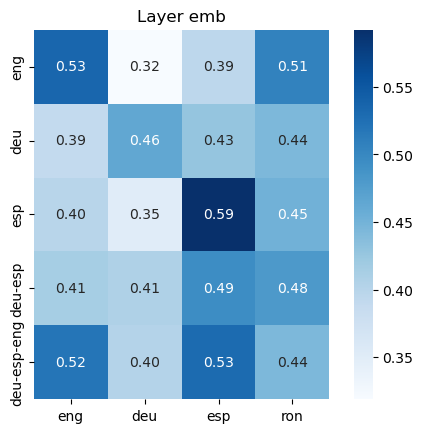

In [22]:
sns.heatmap(tab, xticklabels=TARGET_LANGS, yticklabels=SOURCE_LANGS, fmt='.2f', square=True, cmap='Blues', annot=True)
plt.title('Layer '+layer_ln)
plt.show()

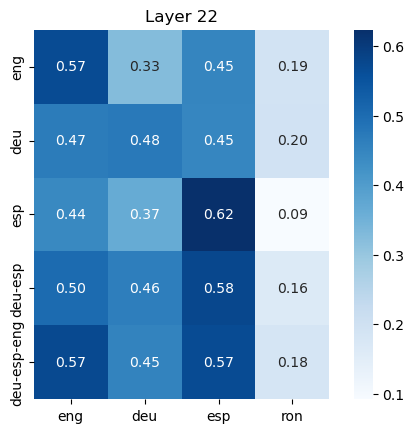

In [7]:
sns.heatmap(tab, xticklabels=TARGET_LANGS, yticklabels=SOURCE_LANGS, fmt='.2f', square=True, cmap='Blues', annot=True)
plt.title('Layer '+layer_ln)
plt.show()

In [4]:
EMB_DIM = {
    'lealla-large': 256,
}
model_name = "setu4993/LEALLA-large"
model_path_name = model_name.lower().split('/')[-1]
device = torch.device('cuda')


src_lang = 'deu-esp-eng'
layer_ln = 'emb'

out_dir = f'./predictions/lp/{src_lang}/track_c/'
os.makedirs(out_dir, exist_ok=True)

path = f'./classifiers/{src_lang}/'
path_layer = path + f'{layer_ln}/'
layer = nn.Linear(EMB_DIM[model_path_name], 1, bias=True)

src_targets = pd.read_csv(f'./data/track_a/train/{src_lang}.csv').columns
src_targets = [c for c in src_targets if c not in ['id', 'text']] ## emotions that predictions can be made for

OOD_LANGS = ['ron', 'ukr', 'hin']

lang_mtds = {
    lang: None for lang in OOD_LANGS
}
lang_targets = {
    lang: None for lang in OOD_LANGS
}
lang_dataloaders = {
    lang: None for lang in OOD_LANGS
}

for lang in OOD_LANGS:
    mtd = pd.read_csv(f'./data/track_c/dev/{lang}.csv')
    lang_mtds[lang] = mtd
    mtd.drop(columns=['text'], inplace=True)

    targets = [c for c in mtd.columns if c not in ['id', 'text']]
    for c in targets:
        if c not in src_targets: # can't make predictions for this emotion; place zeros
            mtd[c] = [0 for _ in range(len(mtd))]
    lang_targets[lang] = targets

    embeddings = np.load(f'./embeddings/{model_path_name}/{lang}/dev.npy')
    embeddings = torch.tensor(embeddings).to(device)

    ds = datasets_local.EmbeddingsDataset(embeddings, np.zeros(len(mtd), dtype=np.float32))
    lang_dataloaders[lang] = DataLoader(ds, batch_size=512, shuffle=False, num_workers=0)

for c in src_targets:
    # load weights for target emotion
    st_path = path_layer + f'model_{c}.pt'
    st = torch.load(st_path)
    layer.load_state_dict(st, strict=False)
    layer.requires_grad_(False)
    layer.to(device)
    layer.eval()
    for lang in OOD_LANGS:
        if c in lang_targets[lang]: # target language has emotion c among its tasks
            dl = lang_dataloaders[lang]
            _, (_, val_preds_), outs_ = utils.validate(layer, device, dl, lambda x, y: torch.ones(1), pred_func=utils.get_predictions_bce, return_out=True)
            lang_mtds[lang][c] = val_preds_.astype(np.int32)

for lang in OOD_LANGS:
    lang_mtds[lang].to_csv(out_dir + f'pred_{lang}.csv', index=False)

tensor(72, device='cuda:0') tensor(72, device='cuda:0')
tensor(81, device='cuda:0') tensor(81, device='cuda:0')
tensor(28, device='cuda:0') tensor(28, device='cuda:0')
tensor(55, device='cuda:0') tensor(55, device='cuda:0')
tensor(67, device='cuda:0') tensor(67, device='cuda:0')
tensor(27, device='cuda:0') tensor(27, device='cuda:0')
tensor(18, device='cuda:0') tensor(18, device='cuda:0')
tensor(52, device='cuda:0') tensor(52, device='cuda:0')
tensor(24, device='cuda:0') tensor(24, device='cuda:0')
tensor(54, device='cuda:0') tensor(54, device='cuda:0')
tensor(130, device='cuda:0') tensor(130, device='cuda:0')
tensor(41, device='cuda:0') tensor(41, device='cuda:0')
tensor(26, device='cuda:0') tensor(26, device='cuda:0')
tensor(53, device='cuda:0') tensor(53, device='cuda:0')
tensor(27, device='cuda:0') tensor(27, device='cuda:0')
tensor(31, device='cuda:0') tensor(31, device='cuda:0')
tensor(111, device='cuda:0') tensor(111, device='cuda:0')
tensor(37, device='cuda:0') tensor(37, devic

/tmp/ipykernel_2854/2817538702.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st = torch.load(st_path)


In [5]:
np.sum(val_preds_)

37